In [1]:
from datetime import datetime, timedelta

import numpy as np
import pandas as pd
from influxdb_client import InfluxDBClient


def get_tag_values(client, tag, bucket, measurement):
    """Get all values under tag."""

    def get_data(range) -> set:
        query = f'''
        from(bucket: "{bucket}")
          |> {range}
          |> filter(fn: (r) => r["_measurement"] == "{measurement}")
          |> keep(columns: ["{tag}"])
          |> group()
          |> distinct(column: "{tag}")
          |> keep(columns: ["_value"])
        '''
        result = query_api.query(query=query)
        result = set(record.get_value() for record in result[0].records)
        return result

    query_api = client.query_api()
    min_existing = int(datetime(year=2023, month=2, day=1).timestamp())
    till_existing = int((datetime.now() - timedelta(days=3)).timestamp())
    min_data = get_data(f"range(start: 0, stop:{min_existing})")
    # max_data = get_data(f"range(start: {till_existing})")

    return min_data

In [3]:
def transform(data, window):
    rules = {
        'open': 'first',
        'close': 'last',
        'high': 'max',
        'low': 'min',
        'number_of_trades': 'sum',
        'quote_asset_volume': 'sum',
        'taker_buy_base_asset_volume': 'sum',
        'taker_buy_quote_asset_volume': 'sum',
        'volume': 'sum'
    }

    data = data.resample(window).agg(rules)
    return data

In [8]:
import tqdm
import pathlib
import pandas as pd

files = list(pathlib.Path("/Users/borsden/Projects/binance_futures/data/klines").glob("*.csv"))

all_data_1m = {}
all_data_5m = {}
all_data_1h = {}
all_data_4h = {}
all_data_1d = {}

for f in tqdm.tqdm(files):
    pair = f.stem

    data_1m = pd.read_csv(f, index_col='_time', parse_dates=['_time'])
    data_1m['close_normalized'] = data_1m['close'] / data_1m['close'].iloc[0]
    data_5m = transform(data_1m, '5m')
    data_1h = transform(data_1m, '1h')
    data_4h = transform(data_1m, '4h')
    data_1d = transform(data_1m, '1d')

    all_data_1m[pair] = data_1m
    all_data_5m[pair] = data_5m
    all_data_1h[pair] = data_1h
    all_data_4h[pair] = data_4h
    all_data_1d[pair] = data_1d


100%|██████████| 157/157 [03:03<00:00,  1.17s/it]


In [54]:
%%time

def get_close(data):
    return pd.DataFrame({k: v['close'] for k, v in data.items()})

def compute_corr(df):
    df_corr = df.corr()
    # df_corr_stacked = df_corr.stack()
    # df_corr = df_corr_stacked.where([a!=b for a, b in df_corr_stacked.index], np.NAN).unstack()

    df_corr = df_corr.where(df_corr.abs() < 0.99, np.NAN)
    return df_corr

# df_1m = get_close(all_data_1m)
df_1h = get_close(all_data_1h)
df_4h = get_close(all_data_4h)
df_1d = get_close(all_data_1d)

df_1d_corr = compute_corr(df_1d)
df_4h_corr = compute_corr(df_4h)
df_1h_corr = compute_corr(df_1h)


CPU times: user 249 ms, sys: 21.3 ms, total: 270 ms
Wall time: 282 ms


<Axes: xlabel='_time'>

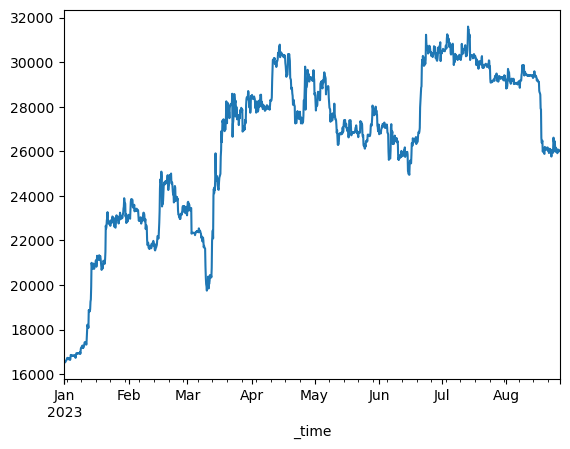

In [55]:
df_4h['btcusdt'].plot()

In [56]:
critical_values = {
    0: {.9: 13.4294, .95: 15.4943, .99: 19.9349},
    1: {.9: 2.7055, .95: 3.8415, .99: 6.6349}
}
trace0_cv = critical_values[0][.95]  # critical value for 0 cointegration relationships
trace1_cv = critical_values[1][.95]  # critical value for 1 cointegration relationship



In [125]:
# import seaborn as sns
#
# cmap = sns.diverging_palette(220, 10, as_cmap=True)
# sns.clustermap(df_1h_corr, cmap=cmap, center=0,  figsize=(40, 40)).savefig('./data/df_1h_corr.png')
# sns.clustermap(df_1m_corr, cmap=cmap, center=0,  figsize=(40, 40)).savefig('./data/df_1m_corr.png')
# sns.clustermap(df_1d_corr, cmap=cmap, center=0,  figsize=(40, 40)).savefig('./data/df_1d_corr.png')
# sns.clustermap(df_4h_corr, cmap=cmap, center=0,  figsize=(40, 40)).savefig('./data/df_4h_corr.png')

In [129]:
# highly_corr_pairs = df_1m_corr.stack()[df_1m_corr.stack() > 0.95].sort_values()
# print(highly_corr_pairs)
# highly_corr_pairs = list(set(tuple(sorted(x)) for x in highly_corr_pairs.index))


In [57]:
from statsmodels.tsa.vector_ar.var_model import VAR

var = VAR(df_1d[['btcusdt', 'ethusdt']])
lags = var.select_order()
order = lags.selected_orders['aic']
order

1

<Axes: xlabel='_time'>

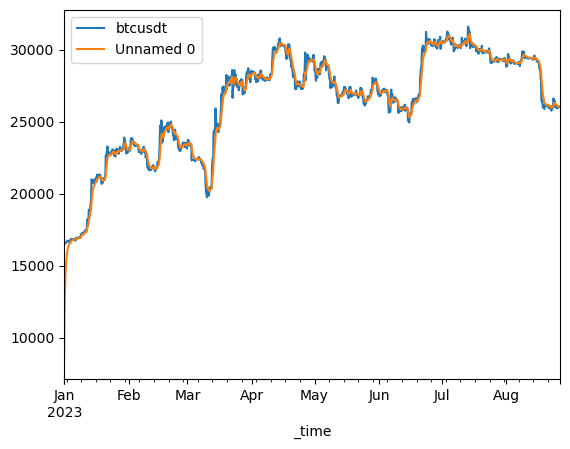

In [58]:
from statsmodels.tsa.statespace.kalman_filter import KalmanFilter
from pykalman import KalmanFilter


def KFSmoother(prices):
    """Estimate rolling mean"""

    kf = KalmanFilter(transition_matrices=np.eye(1),
                      observation_matrices=np.eye(1),
                      initial_state_mean=0,
                      initial_state_covariance=1,
                      observation_covariance=1,
                      transition_covariance=.05)

    state_means, _ = kf.filter(prices.values)
    return pd.Series(state_means.flatten(),
                     index=prices.index)

# import
ddd = pd.DataFrame([df_4h['btcusdt'], KFSmoother(df_4h['btcusdt'])]).T
# ddd.plot()
ddd.plot()

In [21]:
# from statsmodels.tsa.vector_ar.var_model import VAR
#
# var = VAR(df_4h.ffill().bfill())
# lags = var.select_order()

ValueError: x contains one or more constant columns. Column(s) 0 are constant. Adding a constant with trend='c' is not allowed.

In [59]:
df_4h = df_4h.loc[:, ~(pd.isna(df_4h).any())]
df_4h

,ltcbusd,runeusdt,alphausdt,nknusdt,blzusdt,bnbbusd,jasmyusdt,rlcusdt,nearusdt,dentusdt,...,xlmusdt,axsusdt,neousdt,galausdt,maticusdt,antusdt,belusdt,klayusdt,sfpusdt,batusdt
_time,,,,,,,,,,,,,,,,,,,,,
2022-12-31 20:00:00+00:00,70.09,1.273,0.06674,0.07854,0.04934,246.10,0.002943,1.2229,1.255,0.000684,...,0.07105,6.042,6.138,0.01666,0.7580,2.236,0.3885,0.1517,0.3956,0.1662
2023-01-01 00:00:00+00:00,69.39,1.269,0.06525,0.07916,0.04910,245.18,0.002953,1.1907,1.250,0.000704,...,0.07089,6.016,6.137,0.01668,0.7517,2.253,0.3879,0.1515,0.3965,0.1659
2023-01-01 04:00:00+00:00,69.44,1.268,0.06413,0.07897,0.04854,243.95,0.003084,1.2038,1.245,0.000702,...,0.07105,5.958,6.166,0.01651,0.7527,2.244,0.3866,0.1503,0.3954,0.1652
2023-01-01 08:00:00+00:00,70.15,1.276,0.06452,0.07934,0.04879,244.21,0.003054,1.2106,1.251,0.000706,...,0.07178,6.012,6.239,0.01663,0.7567,2.235,0.3884,0.1502,0.3984,0.1657
2023-01-01 12:00:00+00:00,70.28,1.272,0.06476,0.07981,0.04853,244.45,0.003071,1.1908,1.257,0.000707,...,0.07193,6.128,6.366,0.01673,0.7581,2.227,0.3891,0.1497,0.3982,0.1673
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-26 04:00:00+00:00,65.47,1.458,0.08275,0.08352,0.11797,216.99,0.003412,1.0139,1.199,0.000631,...,0.12264,4.844,7.212,0.01930,0.5473,4.230,0.5651,0.1396,0.5232,0.1747
2023-08-26 08:00:00+00:00,65.47,1.411,0.08299,0.08316,0.11750,217.27,0.003378,1.0042,1.202,0.000625,...,0.12338,4.825,7.204,0.01926,0.5477,4.212,0.5627,0.1396,0.5275,0.1754
2023-08-26 12:00:00+00:00,65.47,1.417,0.08245,0.08310,0.11466,217.16,0.003358,0.9937,1.194,0.000621,...,0.12222,4.834,7.181,0.01916,0.5473,4.205,0.5600,0.1396,0.5560,0.1736


In [73]:
import numpy as np

df_4h_corr_stacked = df_4h_corr.stack()
# pd.isna(df_4h_corr_stacked).sum()
pair_combinations = list(df_4h_corr_stacked.index)
# df_4h_corr = df_4h_corr_stacked.where([a != b for a, b in df_4h_corr_stacked.index], np.NAN).unstack()
# df_4h_corr

In [78]:
from statsmodels.tsa.stattools import coint
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.vector_ar.var_model import VAR

for s1, s2 in pair_combinations:
    df = df_4h[[s1, s2]]

    var = VAR(df)
    lags = var.select_order()
    order = lags.selected_orders['aic']
    result = [s1, s2, order]
    result += [coint(df[s1], df[s2], trend='c')[1], coint(df[s2], df[s1], trend='c')[1]]
    cj = coint_johansen(df, det_order=0, k_ar_diff=order)
    result += (list(cj.lr1) + list(cj.lr2) + list(cj.evec[:, cj.ind[0]]))
    break

In [79]:
result

['ltcbusd',
 'runeusdt',
 14,
 0.14764831336628553,
 0.7848016128361142,
 11.58529676952671,
 2.1097812210634697,
 9.475515548463239,
 2.1097812210634697,
 0.12273077694030587,
 0.3836613715454229]

In [74]:
from statsmodels.tsa.stattools import coint
from statsmodels.tsa.vector_ar.vecm import coint_johansen


# def get_cointegrations():

s1, s2 = pair_combinations[0]
df = df_4h[[s1, s2]]

result = [coint(df[s1], df[s2], trend='c')[1], coint(df[s2], df[s1], trend='c')[1]]

cj = coint_johansen(df, det_order=0, k_ar_diff=order)
result + (list(cj.lr1) + list(cj.lr2) + list(cj.evec[:, cj.ind[0]]))

([0.14764831336628553, 0.7848016128361142],
 [8.610318025672415,
  0.9541179522796808,
  7.656200073392734,
  0.9541179522796808,
  0.1052525285700382,
  1.1022208173001131])

In [75]:
df_4h[s1]

_time
2022-12-31 20:00:00+00:00    70.09
2023-01-01 00:00:00+00:00    69.39
2023-01-01 04:00:00+00:00    69.44
2023-01-01 08:00:00+00:00    70.15
2023-01-01 12:00:00+00:00    70.28
                             ...  
2023-08-26 04:00:00+00:00    65.47
2023-08-26 08:00:00+00:00    65.47
2023-08-26 12:00:00+00:00    65.47
2023-08-26 16:00:00+00:00    65.47
2023-08-26 20:00:00+00:00    65.47
Freq: 4H, Name: ltcbusd, Length: 1429, dtype: float64